In [1]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
import porepy as pp

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


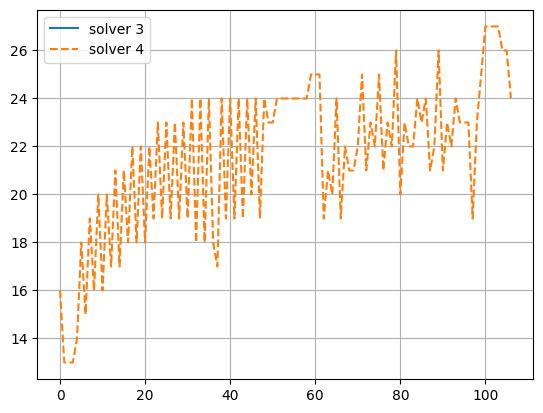

In [2]:
grids = [
    # 1,
    2,
    # 5,
    # 25,
    # 33,
    # 40,
]

sol = [3,4]

data = {}
names = {}
for i, s in enumerate(sol):
    data[i] = load_data(f"../stats/stats_thermal_geo4testx{2}_sol{s}.json")
    names[i] = f"solver {s}"

# for i, g in enumerate(grids):
#     data[i] = load_data(f"../stats/stats_thermal_geo4testx{g}_sol4.json")
#     names[i] = f"Grid x{g}"


shape = [2, 3]
figsize = (12, 4)



plt.gca().grid(True)
set_integer_ticks("vertical")
plt.plot(get_gmres_iterations(data[0]), label=names[0])
plt.plot(get_gmres_iterations(data[1]), label=names[1], linestyle='--')

plt.legend()

# plot_grid(
#     data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
# )

In [3]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from thermal_runscript_4_test import make_model
import porepy as pp

model = make_model(
    {
        "geometry": "4test",
        "solver": 4,
        "grid_refinement": 2,
        "steady_state": True,
        'save_matrix': True,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]



Sim time: 0.00e+00, Dt: 1.00e+00 (days)
Temperature: 393.00, 393.00
sticking: 101, sliding: 0, open: 0


In [4]:
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    load_data(f"../stats/{model.simulation_name()}.json"), 100
)

In [5]:
model.linear_system = mat, rhs
model.bmat.mat = mat
model.equation_system.set_variable_values(state, time_step_index=0)
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.ad_time_step.set_value(dt)

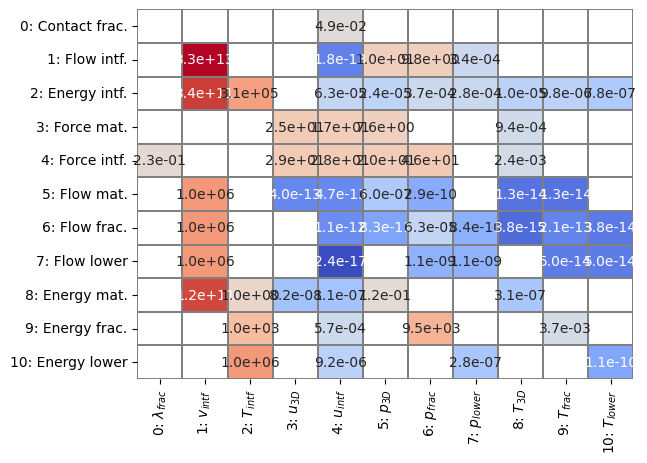

In [6]:
J = model.bmat[:]
J.plot_max()
# J.color_spy()

Construction took: 0.48
KSP Object: 1 MPI process
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with one step of iterative refinement when needed
    happy breakdown tolerance 1e-30
  maximum iterations=120, initial guess is zero
  tolerances:  relative=1e-10, absolute=1e-50, divergence=10000.
  right preconditioning
  using UNPRECONDITIONED norm type for convergence test
PC Object: 1 MPI process
  type: fieldsplit
    FieldSplit with Schur preconditioner, factorization UPPER
    Preconditioner for the Schur complement formed from Sp, an assembled approximation to S, which uses A00's block diagonal's inverse
    Split info:
    Split number 0 Defined by IS
    Split number 1 Defined by IS
    KSP solver for A00 block
      KSP Object: (fieldsplit_0_) 1 MPI process
        type: preonly
        maximum iterations=10000, initial guess is zero
        tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
        left preconditioning
   

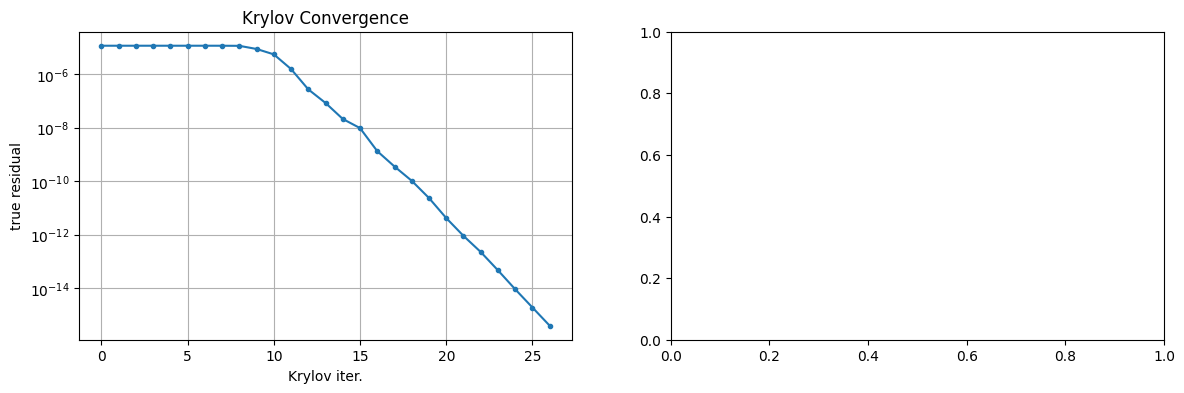

In [14]:
from fixed_stress import make_fs_analytical, make_fs_analytical_slow_new
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *
from full_petsc_solver import *

contact = [0]
intf = [1, 2]
mech = [3, 4]
flow = [5, 6, 7]
temp = [8, 9, 10]
scheme = LinearTransformedScheme(
    right_transformations=[lambda bmat: model.Qright(contact_group=0, u_intf_group=4)],
    inner=PetscKSPScheme(
        petsc_options={
            # 'ksp_max_it': 120,
            "ksp_type": "gmres",
            # "ksp_monitor": None,
            # 'ksp_gmres_modifiedgramschmidt': None,
            # 'ksp_gmres_cgs_refinement_type': 'refine_always',
        },
        preconditioner=PetscFieldSplitScheme(
            groups=contact,
            block_size=model.nd,
            fieldsplit_options={
                "pc_fieldsplit_schur_precondition": "selfp",
            },
            subsolver_options={
                "pc_type": "pbjacobi",
            },
            tmp_options={
                "mat_schur_complement_ainv_type": "blockdiag",
            },
            complement=PetscFieldSplitScheme(
                groups=intf,
                subsolver_options={
                    "pc_type": "ilu",
                },
                fieldsplit_options={
                    "pc_fieldsplit_schur_precondition": "selfp",
                },
                complement=PetscFieldSplitScheme(
                    groups=mech,
                    subsolver_options={
                        "pc_type": "hypre",
                        "pc_hypre_type": "boomeramg",
                        "pc_hypre_boomeramg_strong_threshold": 0.7,
                        "pc_hypre_boomeramg_smooth_type": "Euclid",
                        'pc_hypre_boomeramg_relax_weight_all': 1,
                    },
                    block_size=model.nd,
                    invert=lambda bmat: csr_to_petsc(
                        make_fs_analytical_slow_new(
                            model,
                            bmat,
                            p_mat_group=5,
                            p_frac_group=6,
                            groups=flow + temp,
                        ).mat,
                        bsize=1,
                    ),
                    complement=PetscCPRScheme(
                        groups=flow + temp,
                        pressure_groups=flow,
                        pressure_options={
                            "ksp_type": "preonly",
                            "pc_type": "hypre",
                            "pc_hypre_type": "boomeramg",
                        },
                        others_options={
                            "ksp_type": "preonly",
                            "pc_type": "none",
                        },
                        cpr_options={
                            "pc_composite_pcs": "fieldsplit,ilu",
                        },
                    ),
                ),
            ),
        ),
    ),
)

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=scheme,
    ksp_view=True,
)